In [1]:
from cycloneFilter import cycloneFilter
from solid import *
from solid.utils import *
import viewscad
import math

In [3]:
def crossSectionalArea(*params):
    '''
    calculate the cross sectional area of the given cycloneFilter.
    
    Parameters:
        cycloneFilterParams: parameters that will define a cycloneFilter
    Returns:
        rectangular area of intakeWidth*intakeHeight
    '''
    #POSITIONAL LEGEND:
    # initParams=[intakeSlitHeight=10, intakeSlitWidth=2,
    #     intakeLeft=True, vortexSearcherDepth=5, collectorDepth=75,
    #     cylinderRadius=10, cylinderHeight=15, wallWidth=0.05]
    
    #length times width is easiest calculation since inlet = outlet
    
    return params[0] * params[1]

In [24]:
def cycloneArray(init_params, delta_params, length, width, height):
    '''
    build sequential/parallel array of cyclone filters in a cartesian grid pattern.
    starts by fitting width with init_params cycloneFilter objects, then alters geometry by delta_params
    and adds the equivalent airflow solution of the new cycloneFilter objects to the described rectangular prism.
    Stops when the rectangular prism is filled. through each sequence of delta_params filters the total cross sectional
    area of intakes/outlets is kept constant.
    
    Parameters:
            init_params: list of cycloneFilter positional parameters to start from
            delta_params: list of values that will change each respective positional init_params
            length: array size containing sequential filters
            width: array size containing parallel filters 
            height: array height for filters
    '''
    #TODO: assert each cyclone doesnt cause pressure differentials due to cylinder_radius
    #      being smaller than intake/outlet_radius
    #TODO: assert initial cylinder can fit in the first place (init cylinderRadius)
    #
    #TODO: curtains cause low pressure regions due to square loss across large volume. this increases clog chance greatly
    #      compared to high pressure pipelines minimized for cross section of intake/outlet where constant high velocity fields
    #      keep particle friction dynamic. This is too complicated, would require kernel stride from one sequence to the next.
    #      This would also require coarse grid such as in the initial sequence's intake since theres a venturi differential.
    #
    #DEVELOPMENT:
    #1. carriage return multi row sequences
    #2. curtain on each row
    #3. curtain on each sequence with pipelining input and exhaust
    
    #POSITIONAL LEGEND:
    # initParams=[intakeSlitHeight=10, intakeSlitWidth=2,
    #     intakeLeft=True, vortexSearcherDepth=5, collectorDepth=75,
    #     cylinderRadius=10, cylinderHeight=15, wallWidth=0.05]
    #TODO: set poisitional parameters as dictionary for keyword reference and unpack with ** operator
    #TODO: move this into iterator, can be used to calculate if a extra filter can be added.
    
    #TODO: reorganize all of this conditions are spread out too much
    params = init_params
    curPosition = [0,0]
    array = None
    xDistance, yDistance = 0, 0
    print(params)
   

    #deiterate cross-sectional area in this loop.
    arrayBuffer = [] #holds a cell of filters
    areaSolution = 0 #static total sum of cross sectional area needed in parallel 
                     #for sequence pressure equivalence (not considering pressure loss in filter)
    areaBuffer = 0 #buffer for deiterating areaSolution per row in a sequence
    
    while True: #sequential loop
        print('in the loop')
        
        ########### ITERATE TO NEXT SEQUENCE ###########
        if areaBuffer <= 0 and areaSolution != 0:
            print('\n iterating filter parameters-- new sequence.. \n')
            params = [y(x) for x,y in zip(params, delta_params)]
            #set parameters based on given equation matrix, wallWidth is only float.
            paramsBuffer = [int(x) for x in params[:-1]]
            paramsBuffer.append(params[len(params)-1])
            params = paramsBuffer
            print(params)
            areaBuffer = areaSolution
            
            print('appending filters')
            #dump the buffer into the solution object
            for cyclone in arrayBuffer:
                if array is None:
                    array = cyclone
                else:
                    array+=cyclone
                    
            arrayBuffer.clear()
        
        #keep z dimension the same throughout array by mutating collector depth
        #TODO: this should be extracted and integrated into collectorDepth parameter
        if params[6] + params[4] < height:
            params[4] += height - (params[6] + params[4])
        elif params[6] + params[4] > height:
            params[4] -= (params[6] + params[4]) - height
        
        curPosition[1] += yDistance #y position
        curPosition[0] = 0 #carriage return x axis
        
        #distance between each filter
        xDistance = 2*params[5] + params[7] + 2*sqrt(params[1]*params[0]/pi)
        yDistance = 2.5*params[5] + params[7] 
        
        parallelFilters = math.ceil(width/xDistance)
        print('sequence contains {} parallel filters'.format(parallelFilters))
        
        ########### INITIALIZE ###########
        if areaSolution == 0:
            #first filter sequence sets areaSolution (currently just one row is initial cell)
            areaSolution = parallelFilters*crossSectionalArea(*params)
            areaBuffer = areaSolution
            print('initialized areaSolution: {} areaBuffer: {}'.format(areaSolution, areaBuffer))
            
        if curPosition[1] > length:
            print('EOL: filter sequence')
            print('dumping {} cyclone filters from last sequence clipping'.format(len(arrayBuffer)))
            arrayBuffer.clear()
            break
                    
        ########### ADD FILTERS TO CURRENT SEQUENCE###########
        #TODO: add manifold during construction
        #each row has a collector 'tube' and hook ups to manifold
        #rectangular prism with cylinders on either end with diameter aligned along height edge of each prism from pi/2 to 3pi/2
        #at end of row, set collector tube and hook ups for exhaust and intake
        #at end of sequence, set exhaust manifold
        #two manifolds, one for intake and one for exhaust
        print('parallelFilters {} mod 2 is {}'.format(parallelFilters, parallelFilters%2))
        if parallelFilters%2 != 0:
            if areaBuffer <= 0:
                #reached parallel cross-sectional area equivalence
                break
                
            print('odd')
            #start from origin then offset each filter origin+xDistance
            initialFilter = cycloneFilter(*params)
            initialFilter = left(curPosition[0])(initialFilter)
            initialFilter = forward(curPosition[1])(initialFilter)
            curPosition[0] += xDistance
            
            arrayBuffer.append(initialFilter)
            areaBuffer -= crossSectionalArea(*params)
            print('areaBuffer: {}'.format(areaBuffer))
            
            #parallel loop parallel_filters is int so /2 is okay
            #TODO: this is likely overstepping the area? double check this
            for x in range(int((parallelFilters-1)//2)): 
                print('areaBuffer: {}'.format(areaBuffer))
                if areaBuffer <= 0:
                    #reached parallel cross-sectional area equivalence
                    break
                
                leftParams = params
                leftParams[2] = False
                leftFilter = cycloneFilter(*leftParams)
                leftFilter = left(curPosition[0])(leftFilter)
                leftFilter = forward(curPosition[1])(leftFilter)
                
                rightParams = params
                rightParams[2] = True
                rightFilter = cycloneFilter(*rightParams)
                rightFilter = right(curPosition[0])(rightFilter)
                rightFilter = forward(curPosition[1])(rightFilter)
                curPosition[0] += xDistance
                
                arrayBuffer.append(leftFilter)
                areaBuffer -= crossSectionalArea(*params)
                arrayBuffer.append(rightFilter)
                areaBuffer -= crossSectionalArea(*params)
                
        else:
            print('even')
            #start from origin + xDistance/2
            curPosition[0] += xDistance/2
            for x in range(int(parallelFilters//2)): #parallel loop
                print('areaBuffer: {}'.format(areaBuffer))
                if areaBuffer <= 0:
                    #reached parallel cross-sectional area equivalence
                    break
                
                leftParams = params
                leftParams[2] = False
                leftFilter = cycloneFilter(*leftParams)
                leftFilter = left(curPosition[0])(leftFilter)
                leftFilter = forward(curPosition[1])(leftFilter)

                rightParams = params
                rightParams[2] = True
                rightFilter = cycloneFilter(*rightParams)
                rightFilter = right(curPosition[0])(rightFilter)
                rightFilter = forward(curPosition[1])(rightFilter)
                curPosition[0] += xDistance
                
                arrayBuffer.append(leftFilter)
                areaBuffer -= crossSectionalArea(*params)
                arrayBuffer.append(rightFilter)
                areaBuffer -= crossSectionalArea(*params)
        
    return array

[20000, 1000, True, 500, 3000, 20000, 20000, 100]
in the loop
sequence contains 2 parallel filters
initialized areaSolution: 40000000 areaBuffer: 40000000
parallelFilters 2 mod 2 is 0
even
areaBuffer: 40000000
in the loop

 iterating filter parameters-- new sequence.. 

[10000, 1000, 1, 500, 10000, 10000, 15000, 100]
appending filters
sequence contains 3 parallel filters
parallelFilters 3 mod 2 is 1
odd
areaBuffer: 30000000
areaBuffer: 30000000
in the loop
sequence contains 3 parallel filters
parallelFilters 3 mod 2 is 1
odd
areaBuffer: 0
areaBuffer: 0
in the loop

 iterating filter parameters-- new sequence.. 

[5000, 1000, 1, 500, 15000, 5000, 11250, 100]
appending filters
sequence contains 4 parallel filters
parallelFilters 4 mod 2 is 0
even
areaBuffer: 40000000
areaBuffer: 30000000
in the loop
sequence contains 4 parallel filters
parallelFilters 4 mod 2 is 0
even
areaBuffer: 20000000
areaBuffer: 10000000
in the loop

 iterating filter parameters-- new sequence.. 

[2500, 1000, 1, 5

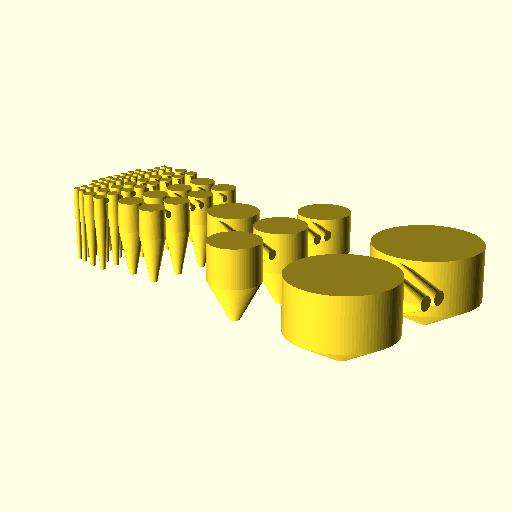

In [25]:
#POSITIONAL LEGEND:
# initParams=[intakeSlitHeight=10, intakeSlitWidth=2,
#     intakeLeft=True, vortexSearcherDepth=5, collectorDepth=75,
#     cylinderRadius=10, cylinderHeight=15, wallWidth=0.05]
init_params=[20000, 1000, 
            True, 500, 3000,
            20000, 20000, 100]
#reduction methods
geometric_reduction = lambda x: x/2 if x/2 > 1000 else 1000 #add floor bound
geometric_reduction_height = lambda x: x - x/4 if x - x/4 > 1000 else 1000
null = lambda x: x

delta_params=[geometric_reduction, null,
              null, null, null,
              geometric_reduction, geometric_reduction_height, null]

cycloneArray = cycloneArray(init_params, delta_params, 150000, 50000, 30000)
print('done', cycloneArray)
cycloneArray

In [26]:
############# Writeout Filter Model #############
scad_render_to_file(
    cycloneArray,
    "cycloneArray.scad",
)

True

In [24]:
#center point of intake:
#center point of outlet:

True

### MANIFOLD PIPELINE AND INTERFACES
- intake needs a grid for coarse grain filtering with squares of the smallest dimension (intakeSlitWidth) and exhaust needs cone with exponential slope (horn) to match radial compressor (these will be interface geometries to this module and should be designed seperately).
- also can have no manifold and seal off each row, exposing only the outlet of previous layer and inlet of next. highest clog chance Also works with creating a box around the cyclone array. can also remove most of the intake nozzle, essentially leaving a rectangular slit as the inlet.

- set a manfold receptacle for intake and outlet respectively, extruded rectangular prism of width, height=intake_diameter. connect each with simple vertical+horizontal ventillation attached at 90 degrees that connects each receptacle per sequence. consider an extremely elongated elipse linearly extruded (rectangle with both smaller sides curved) to reduce swirl against sharp edges (edges of rectanglular prism w.r.t. inlets)

- empirically verify cyclone clogging. Clearview cyclone clogs due to very large pressure differential to inner cyclone intake, limiting larger particles which have a chance to disrupt small particle agglomeration. need collision oriented filtration/energy loss to avoid aglomeration and therefore latent clogging in the sequence.
- E.G.: beads of glass or large sand traveling through, striking dust agglomerates can act as a rudimentary cleaning method if flow fields are even throughout the manifold (large volumes can cause beads to lose energy before traveling the same path as dust particulates, falling out of primary streamline and reducing clog striking chance).

### CONSTRAINTS 
- increase  parallel splits based on intake **cross sectional area** to keep total cross sectional area across all filters the same per sequence
- this requires manifold pipeline to allow residual 'skip' connections to the next row, in cases where a single row of the new delta_param iterated geometry doesnt fulfill cross sectional inlet/outlet equivalence. This is critical for optimal pressure differential (energy going into filtering not venturi loss).
- arrayConstraints for parametric interface: rect. prism [x,y,z]

### TODOS 
- GITHUB: set project sub-directory for cyclone filtration modules. label a README to make this discoverable through google crawlers.
- consider a hair filter or long slender blob filter as these are the worst case for this geometry of cyclone filter. should be okay with a low pressure, high volume intake zone before the cycloneArray (see drawing).
- is it okay to have negative areaBuffer in a sequence? may cause pressure to drop in this sequence, reducing airflow and therefore angular velocity therefore centripetal acceleration of particulates.
- consider initial cyclone with no collector cone as vortex isnt as necessary with very large mass blobs. need to consider how this will perturb the collection bin wrt future sequence filter collector backfeeding.

### FUTURE DEVELOPMENT
- create a radial array arrangement as well, attempt to reuse fitting optimization code from cycloneArray() for abstract geometries
